# Style Transfer 3
Perfect and complete explanation - [Artistic Style Transfer by Naoki Shibuya](https://github.com/naokishibuya/deep-learning/blob/master/python/artistic_style_transfer.ipynb)
## Libraries

In [1]:
%tensorflow_version 1.x

TensorFlow 1.x selected.


In [2]:
import warnings; warnings.filterwarnings('ignore')
import urllib,cv2
from PIL import Image
import numpy as np,tensorflow as tf,pylab as pl,keras as ks
from tqdm import tqdm
fpath='https://olgabelitskaya.github.io/'
style_layers=['block1_conv1','block2_conv1','block3_conv1',
              'block4_conv1','block5_conv1']

Using TensorFlow backend.


In [0]:
#from google.colab import files
#uploaded=files.upload()

In [0]:
#!ls

In [0]:
#for k,v in uploaded.items():
#    open(k,'wb').write(v)

## Displaying Vertical Images

In [0]:
def display_images(original,style,fpath=fpath):
    input_file=urllib.request.urlopen(fpath+original)
    output_file=open(original,'wb'); 
    output_file.write(input_file.read())
    output_file.close(); input_file.close()
    input_file=urllib.request.urlopen(fpath+style)
    output_file=open(style,'wb'); 
    output_file.write(input_file.read())
    output_file.close(); input_file.close()
    original_img=cv2.imread(original)
    style_img=cv2.imread(style)    
    pl.figure(1,figsize=(12,4))
    pl.subplot(121)
    pl.title("Shape of the original image: %s"%str(original_img.shape))
    pl.imshow(cv2.cvtColor(original_img,cv2.COLOR_BGR2RGB))
    pl.subplot(122)
    pl.title("Shape of the style image: %s"%str(style_img.shape))
    pl.imshow(cv2.cvtColor(style_img,cv2.COLOR_BGR2RGB)); pl.show()

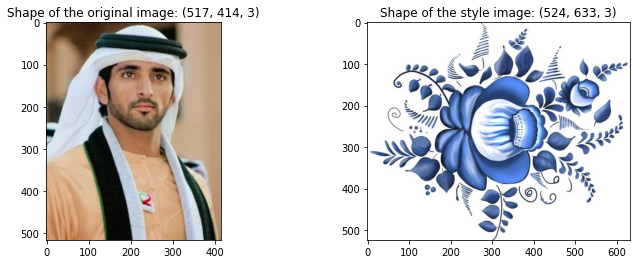

In [7]:
display_images('HMRM.png','pattern02.png')

## Preprocessing

In [0]:
def rr_img(image,angle,width,height):
    [h,w]=image.shape[:2]; x,y=w//2,h//2
    M=cv2.getRotationMatrix2D((x,y),-angle,1.)
    cos,sin=np.abs(M[0,0]),np.abs(M[0,1])
    nw,nh=int((h*sin)+(w*cos)),int((h*cos)+(w*sin))
    M[0,2]+=(nw/2)-x; M[1,2]+=(nh/2)-y
    img=cv2.warpAffine(image,M,(nw,nh))
    return cv2.resize(img,(width,height)).astype('float32')

In [9]:
picture01=cv2.imread('HMRM.png').astype('float32')
pattern01=cv2.imread('pattern02.png').astype('float32')
picture01=rr_img(picture01,90,500,400)
pattern01=rr_img(pattern01,0,500,400)
picture01.shape,pattern01.shape

((400, 500, 3), (400, 500, 3))

In [10]:
picture01[1]

array([[ 72.134964,  89.985855, 108.88044 ],
       [142.34041 , 177.44542 , 214.6029  ],
       [142.79    , 177.85251 , 215.05249 ],
       ...,
       [102.1765  , 132.35027 , 164.40276 ],
       [103.68721 , 132.8944  , 165.39648 ],
       [105.7297  , 133.95583 , 166.45627 ]], dtype=float32)

In [0]:
def preprocess(img):
    img=img.copy(); img=np.expand_dims(img,axis=0) 
    return ks.applications.vgg16.preprocess_input(img)
def deprocess(img):
    img=img.copy()[0]                        
    img[:,:,0]+=103.939; img[:,:,1]+=116.779; img[:,:,2]+=123.68             
    img=img[:,:,::-1]              
    img=np.clip(img,0,255)         
    return img.astype('uint8') 

In [0]:
def inputs(original_img,style_img):
    original_input=tf.constant(preprocess(original_img))
    style_input=tf.constant(preprocess(style_img))
    generated_input=tf.placeholder(tf.float32,original_input.shape)
    return original_input,style_input,generated_input

In [13]:
original_input,style_input,generated_input=\
inputs(picture01,pattern01)
input_tensor=tf.concat([original_input,style_input,
                        generated_input],axis=0)
input_tensor.shape

TensorShape([Dimension(3), Dimension(400), Dimension(500), Dimension(3)])

## VGG16 Usage

In [14]:
vgg16_model=ks.applications.vgg16.\
VGG16(input_tensor=input_tensor,include_top=False)
vgg16_layer_dict={layer.name:layer for layer in vgg16_model.layers}
vgg16_model.summary()




58892288/58889256 [==============================] - 3s 0us/step






Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, None, None, 3)     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, None, None, 64)    1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, None, None, 64)    36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, None, None, 64)    0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, None, None, 128)   73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, None, None, 128)   147584    
_____________________________________________________

In [0]:
def calculate_original_loss(layer_dict,original_layer_names):
    loss=0
    for name in original_layer_names:
        layer=layer_dict[name]
        original_features=layer.output[0,:,:,:]  
        generated_features=layer.output[2,:,:,:] 
        loss+=ks.backend.sum(ks.backend.square(generated_features-original_features))
    return loss/len(original_layer_names)
def gram_matrix(x):    
    features=ks.backend.batch_flatten(ks.backend.permute_dimensions(x,(2,0,1))) 
    gram=ks.backend.dot(features,ks.backend.transpose(features))
    return gram
def get_style_loss(style_features,generated_features,size):
    S=gram_matrix(style_features)
    G=gram_matrix(generated_features)
    channels=3
    return ks.backend.sum(ks.backend.square(S-G))/(4.*(channels**2)*(size**2))
def calculate_style_loss(layer_dict,style_layer_names,size):
    loss=0
    for name in style_layer_names:
        layer=layer_dict[name]
        style_features=layer.output[1,:,:,:] 
        generated_features=layer.output[2,:,:,:] 
        loss+=get_style_loss(style_features,generated_features,size) 
    return loss/len(style_layer_names)
def calculate_variation_loss(x):
    row_diff=ks.backend.square(x[:,:-1,:-1,:]-x[:,1:,:-1,:])
    col_diff=ks.backend.square(x[:,:-1,:-1,:]-x[:,:-1,1:,:])
    return ks.backend.sum(ks.backend.pow(row_diff+col_diff,1.25))

In [0]:
original_loss=calculate_original_loss(vgg16_layer_dict,['block5_conv2'])
style_loss=calculate_style_loss(vgg16_layer_dict,style_layers, 
                                pattern01.shape[0]*pattern01.shape[1])
variation_loss=calculate_variation_loss(generated_input)

## Generated Images

In [17]:
loss=.7*original_loss+1.*style_loss+.1*variation_loss    
gradients=ks.backend.gradients(loss,generated_input)[0]
calculate=ks.backend.function([generated_input],[loss,gradients])
generated_data=preprocess(picture01) 
for i in tqdm(range(20)):
    _,gradients_value=calculate([generated_data])
    generated_data-=gradients_value*.001

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


100%|██████████| 20/20 [00:09<00:00,  2.16it/s]


In [18]:
loss=.7*original_loss+1.*style_loss+.1*variation_loss    
gradients=ks.backend.gradients(loss,generated_input)[0]
calculate=ks.backend.function([generated_input],[loss,gradients])
generated_data2=preprocess(picture01) 
for i in tqdm(range(200)):
    _,gradients_value=calculate([generated_data2])
    generated_data2-=gradients_value*.001

100%|██████████| 200/200 [00:20<00:00,  9.55it/s]


In [0]:
#numpy.save('generated_data.npy',generated_data)
#numpy.save('generated_data2.npy',generated_data2)

In [0]:
# generated_data=numpy.load('generated_data.npy')
# generated_data2=numpy.load('generated_data2.npy')

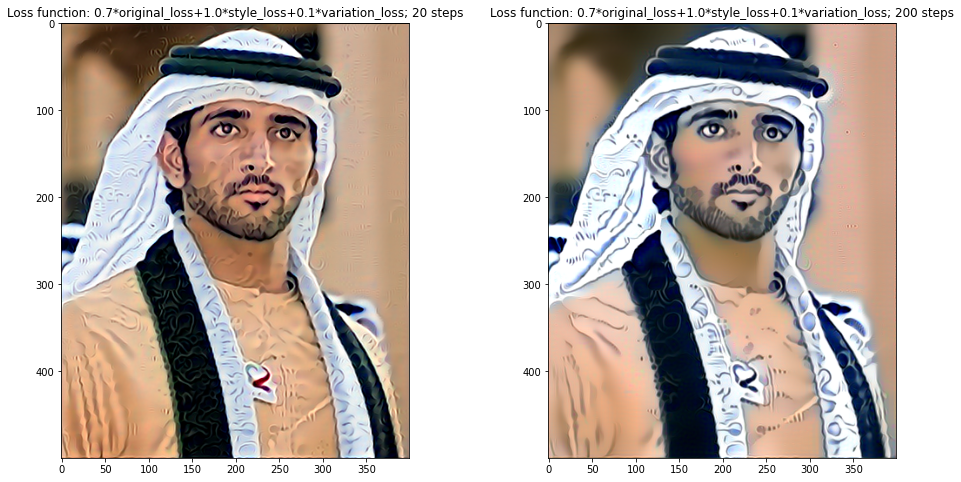

In [21]:
generated_image01=deprocess(generated_data)
generated_image02=deprocess(generated_data2)
generated_image01=rr_img(generated_image01,270,400,500)/255
generated_image02=rr_img(generated_image02,270,400,500)/255
pl.figure(1,figsize=(16,8))
pl.subplot(121)
pl.title("Loss function: 0.7*original_loss+1.0*style_loss+0.1*variation_loss; 20 steps")
pl.imshow(cv2.cvtColor(generated_image01,cv2.COLOR_BGR2RGB))
pl.subplot(122)
pl.title("Loss function: 0.7*original_loss+1.0*style_loss+0.1*variation_loss; 200 steps")
pl.imshow(cv2.cvtColor(generated_image02,cv2.COLOR_BGR2RGB))
pl.show()

## Displaying Horizontal Images

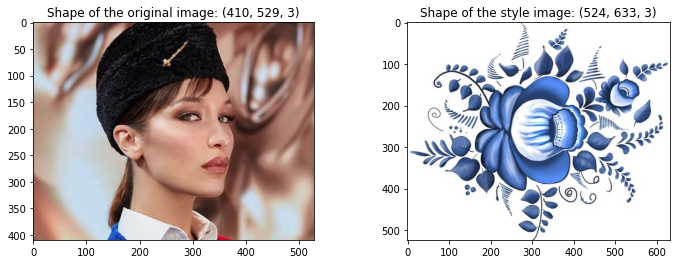

In [22]:
display_images('BH.png','pattern02.png')

## Generated Images

In [25]:
picture01=cv2.imread('BH.png').astype('float32')
pattern01=cv2.imread('pattern02.png').astype('float32')
picture01=cv2.resize(picture01,
                     (pattern01.shape[1],
                      pattern01.shape[0])).astype('float32')
original_input,style_input,generated_input=\
inputs(picture01,pattern01)
input_tensor=tf.concat([original_input,style_input,
                        generated_input],axis=0)
input_tensor.shape

TensorShape([Dimension(3), Dimension(524), Dimension(633), Dimension(3)])

In [26]:
picture01[1]

array([[185.65266 , 192.65268 , 202.      ],
       [185.14503 , 192.65268 , 202.      ],
       [184.979   , 192.65268 , 201.60303 ],
       ...,
       [ 62.356934,  69.57542 , 110.5354  ],
       [ 59.34105 ,  67.34105 , 106.01416 ],
       [ 57.326336,  65.32634 , 103.      ]], dtype=float32)

In [0]:
vgg16_model=ks.applications.vgg16.\
VGG16(input_tensor=input_tensor,include_top=False)
vgg16_layer_dict={layer.name:layer for layer in vgg16_model.layers}
original_loss=calculate_original_loss(vgg16_layer_dict,['block5_conv2'])
style_loss=calculate_style_loss(vgg16_layer_dict,style_layers, 
                                pattern01.shape[0]*pattern01.shape[1])
variation_loss=calculate_variation_loss(generated_input)

In [28]:
loss=.5*original_loss+1.*style_loss+.1*variation_loss    
gradients=ks.backend.gradients(loss,generated_input)[0]
calculate=ks.backend.function([generated_input],[loss,gradients])
generated_data=preprocess(picture01) 
for i in tqdm(range(70)):
    _,gradients_value=calculate([generated_data])
    generated_data-=gradients_value*.001

100%|██████████| 70/70 [00:13<00:00,  5.26it/s]


In [0]:
loss=.5*original_loss+1.*style_loss+.1*variation_loss    
gradients=ks.backend.gradients(loss,generated_input)[0]
calculate=ks.backend.function([generated_input],[loss,gradients])
generated_data2=preprocess(picture01) 
for i in tqdm(range(7000)):
    _,gradients_value=calculate([generated_data2])
    generated_data2-=gradients_value*.001

 29%|██▉       | 2054/7000 [05:42<13:47,  5.98it/s]

In [0]:
generated_image01=deprocess(generated_data)
generated_image02=deprocess(generated_data2)
pl.figure(1,figsize=(16,8))
pl.subplot(121)
pl.title("Loss function: 0.5*original_loss+1.0*style_loss+0.1*variation_loss; 70 steps")
pl.imshow(cv2.cvtColor(generated_image01,cv2.COLOR_BGR2RGB))
pl.subplot(122)
pl.title("Loss function: 0.5*original_loss+1.0*style_loss+0.1*variation_loss; 7000 steps")
pl.imshow(cv2.cvtColor(generated_image02,cv2.COLOR_BGR2RGB))
pl.show()